In [1]:
# general packages
import os, re, yaml
from operator import itemgetter

# scientific packages
import numpy as np
import pandas as pd # to read and work on large datasets
import matplotlib.pyplot as plt
# to allow proper LaTeX formating in figures:
from matplotlib import rc
rc('text', usetex=True)

import mushdynamics as md

# The fate of liquids trapped during the Earth’s inner core growth

This notebook gathers all the code to make the figures in the publication Lasbleis & Kervazo. 
The data needed to make some of the plots are in the subfolder ./data/, and only the required values are given there. For each figure and runs, indications on how to re-runs the entire dataset are given, but not expected to be run through the notebooks as would be too long. 

This notebook is based on the python package mushdynamics, available on https://github.com/MarineLasbleis/mushdynamics. Please refer to the README for installation processes. 

## Figure 1: example of growth scenarios

Dt supercooling 0.48899999999999993
1.0
0.5


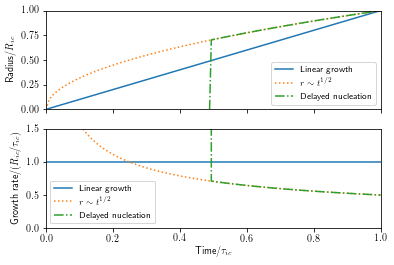

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # for the sake of lisibility, we remove the warnings here
    md.growth.plot_growth([6, 4])

## Figure 2: Linear and $r\propto \sqrt{t}$ growth scenarios

### Regime diagram for linear growth (panels [A] and [B])

Here, we have explore a large range of parameters (final radius of inner core and growth rate) and extracted the values of the average porosity and the thickness of the uppermost mushy layer. 

We give a panda frame containing all the interesting values (obtained from the statistics file) for all the runs in ./data/diag_linear.csv 

You can also re-run all the simulations. To do so, please refer to the Tutorial notebook. We added some random noise in the values of the parameters to avoid getting artificial lines or trend on the regime diagram. Note that the values at either small radius and/or large growth rate do not need to be very well refine in radius (~1000 or 2000 points OK in radius), while to obtain correct values in thickness you will need to drastically increase the number of points in radius for large IC radius and low growth rate. Runs here have been done with some up to 20,000 points in radius. On the computer used for the runs, this required to use up to 6 cores to run, due to the creation of large tridiagonal matrices.

In [3]:
diag_linear = pd.read_csv("./data/diag_linear.csv")

print("Columns in the dataframe: {}".format(diag_linear.columns.values))

Columns in the dataframe: ['Nmax' 'Ric_adim' 'delta' 'exp' 'folder' 'phi_r' 'phi_top' 'remarks'
 'sum_phi' 'tau_ic' 'dot_r']


Here, we will use the columns: 

- 'Ric_adim' : radius of IC (unit is compaction lenght)
- 'dot_r': growth rate (unit is Darcy velocity)
- 'sum_phi': average of porosity
- 'delta': thickness of upper most layer

In [18]:
def diagram(df, ylim=[-2, 2.5], xlim=[-4, 3], N=50):
    """ Build the regime diagram from the data frame df """
    
    x = np.log10(np.array(df["dot_r"].values).astype(float))
    y = np.log10(np.array(df["Ric_adim"].values).astype(float)) # radius IC
    delta = np.log10(np.array(df["delta"].values).astype(float)/np.array(df["Ric_adim"].values).astype(float))
    phi = np.array(df["sum_phi"].values).astype(float) # 
    phir = np.array(df["phi_r"].values).astype(float) # 
    
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 3])
    cmap = plt.cm.magma
    cntr1 = ax[0].tricontourf(x, y, delta, levels=np.linspace(-4, 4, N),  cmap=cmap)
    cntr2 = ax[1].tricontourf(x, y, phi, levels=np.linspace(0, 0.4, N),  cmap=cmap)
    cbar1 = plt.colorbar(cntr1, ax=ax[0], ticks=np.linspace(-4, 4, 9))
    cbar1.ax.set_ylabel("$\ln_{10}\delta_{ul}/\dot{R}_{{ic}}( \tau_{{ic}})$")
    cbar2 = plt.colorbar(cntr2, ax=ax[1], ticks=[0., 0.1, 0.2, 0.3, 0.4])
    cbar2.ax.set_ylabel(r"$<\phi>$")
    ax[0].set_title("Thickness of upper layer")
    ax[1].set_title("Average porosity")
    ax[0].set_xlabel(r"$\ln_{10}\dot{R}_{{ic}}( \tau_{{ic}})/V_D$")
    ax[0].set_ylabel(r"$\ln_{10}R_{{ic}}/\delta$")
    ax[1].set_xlabel(r"$\ln_{10}\dot{R}_{{ic}}( \tau_{{ic}})/V_D$")
    ax[0].set_ylim(ylim)
    ax[0].set_xlim(xlim)
    return fig, ax

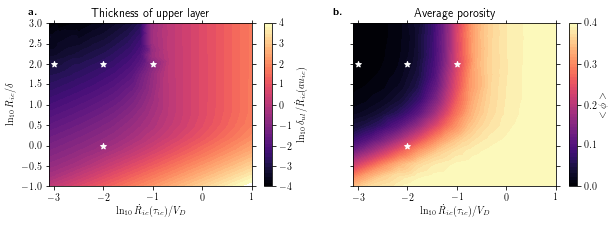

In [35]:
fig, ax = diagram(diag_linear, ylim=[-1, 3], xlim=[-3.1, 1])

# We had the points corresponding to the cases plotted after
R = [2, 2, 2, 0]
dot_R = [-3, -2, -1, -2]

for i, text in enumerate(["a", "b"]):
    
    ax[i].tick_params(direction="out", top=True, right=True)
    ax[i].scatter(dot_R, R, c="w", marker="*")
    ax[i].text(-0.1, 1.10, r"\textbf{"+text+".}", transform=ax[i].transAxes, fontsize=11,
                verticalalignment='top')
    
plt.savefig("Diagram_n3_exp1.pdf")

### Examples of growth history with linear and $r\propto\sqrt{t}$ growth scenarios (panels [C] and [D])

We use here the full outputs from the runs, with up to 200 snapshots per runs to create a clean plot. 

To create all the various plots, we define a function which plot one of the run.

We also need a function to extract the info from the statistics files. 

In [27]:
regex = re.compile(r'\d+')
def find_float(filename):
    numbers = regex.findall(filename) # gives 2 numbers as number with format "1.05" returns 1 and 05
    return float(numbers[0] + '.' + numbers[1])

def extract_files(subfolder):
        list_files = os.listdir(subfolder)
        timesteps = {}
        for file in list_files:
            if file[-14:] == "statistics.txt":
                file_stat = subfolder + "/" + file
            elif file[-9:] == ".timestep":
                _name = subfolder + "/" + file
                _time = find_float(file)
                timesteps[_name] = _time
            elif file[-5:] == ".yaml":
                with open(subfolder + "/" + file, 'r') as stream:
                    try:
                        param = yaml.safe_load(stream)
                    except yaml.YAMLError as exc:
                        print(exc)
        return file_stat, param, timesteps

def figure_lineaire(folder, ax3, fig3):
    """ Porosity structure evolution with time """
    
    file_stat, param, timesteps = extract_files(folder)
    name_max = max(timesteps.items(), key=itemgetter(1))[0]
    data = pd.read_csv(name_max, sep=" ")
    dr = data["radius"][1]-data["radius"][0]
    Radius = np.array(data["radius"].values)+ dr / 2.
    param["dot_r"] = param["Ric_adim"]/param["time_max"]*param["growth_rate_exponent"]

    Time = np.array(sorted(timesteps.values()))
    rayon = np.zeros_like(Time)    

    X, Y = np.meshgrid(Time, Radius)
    Z = 0.4*np.ones_like(X)

    for i, (name, time) in enumerate(sorted(timesteps.items(), key = itemgetter(1))):
        data = pd.read_csv(name, sep=" ")
        dr = data["radius"][1]-data["radius"][0]
        Porosity = np.array(data["porosity"].values)
        N_r = len(Porosity)
        Z[:N_r, i] = Porosity
        rayon[i] = data["radius"].iloc[-1]

    levels = np.linspace(0, 0.4, 41)
    sc = ax3.contourf(X, Y, Z, levels=levels, vmin=0, vmax = 0.4, cmap=plt.cm.get_cmap("pink"))
    cb = fig3.colorbar(sc, ax=ax3, ticks=[0, 0.1, 0.2, 0.3, 0.4]) #, boundaries=np.linspace(0, 0.4, 6))
    ax3.set_xlim([0., time])
    ax3.plot(Time, rayon, 'k')
    cb.set_label("$\phi$")
    textstr = '\n'.join((
                    r"$R_{{ic}}=${:.0f}".format(param["Ric_adim"]),
                    r"$\dot R_{{ic}}=${:.0e}".format(param["dot_r"])))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax3.text(0.05, 0.90, textstr, transform=ax3.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

Then we define the folders containing the data:

In [38]:
base = "./data/"
folders = ["exp_1.00e+00_coeff_1.00e-03_radius_1.00e+02",
           "exp_1.00e+00_coeff_1.00e-02_radius_1.00e+02", 
           "exp_1.00e+00_coeff_1.00e-01_radius_1.00e+02",
           "exp_1.00e+00_coeff_1.00e-02_radius_1.00e+00"]
folders_05=["exp_5.00e-01_coeff_4.47e-01_radius_1.00e+02",
            "exp_5.00e-01_coeff_1.41e+00_radius_1.00e+02",
            "exp_5.00e-01_coeff_4.47e+00_radius_1.00e+02",
           "exp_5.00e-01_coeff_1.41e-01_radius_1.00e+00"]

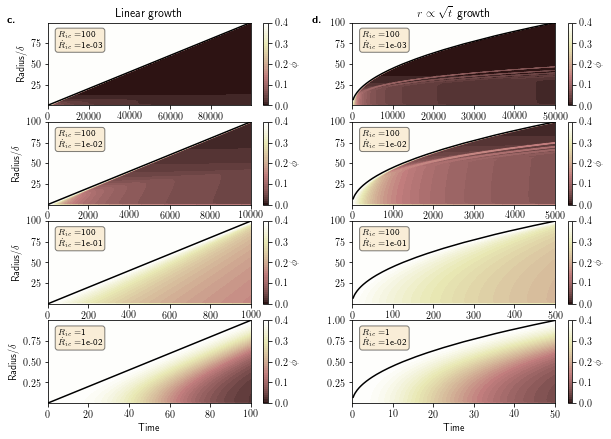

In [39]:
N_fig = len(folders)
fig, ax = plt.subplots(N_fig, 2, figsize=[10, 7])

for i, folder in enumerate(folders):
    
    figure_lineaire(base+folder, ax[i, 0], fig)
    figure_lineaire(base+folders_05[i], ax[i, 1], fig)
    
    ax[i, 0].set_ylabel("Radius$/\delta$")

ax[-1, 0].set_xlabel("Time")
ax[-1, 1].set_xlabel("Time")
ax[0, 0].set_title("Linear growth")
ax[0, 1].set_title(r"$r\propto\sqrt{t}$ growth")

ax[0, 0].text(-0.2, 1.10, r"\textbf{c.}", transform=ax[0, 0].transAxes, fontsize=11,
            verticalalignment='top')
ax[0, 1].text(-0.2, 1.10, r"\textbf{d.}", transform=ax[0, 1].transAxes, fontsize=11,
            verticalalignment='top')

plt.savefig("different_growth.pdf")

## Figure 3: supercooling

### Average porosity as function of growth rate, radius and delay in nucleation (panel [A])

For the same reason than previously, we only provide the final values for this panel. 

In [40]:
supercooling = pd.read_csv("./data/supercooling.csv")
print("Columns in the dataframe: {}".format(diag_linear.columns.values))

Columns in the dataframe: ['Nmax' 'Ric_adim' 'delta' 'exp' 'folder' 'phi_r' 'phi_top' 'remarks'
 'sum_phi' 'tau_ic' 'dot_r']


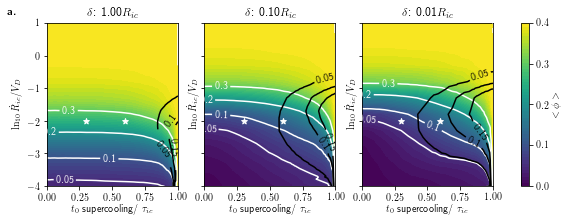

In [41]:
def select_unique(dataframe):
    values = dataframe.unique()
    keep_values = np.abs(np.diff(values))>1e-12
    keep_values = np.insert(keep_values,0,True)
    return values[keep_values]

radii = [1., 10., 100.]#select_unique(df["Ric_adim"])
fig2, ax2 = plt.subplots(1, len(radii),figsize=[10, 3], sharey=True)


for i_fig, radius in enumerate(radii):
    values = supercooling[np.abs(supercooling["Ric_adim"]-radius)<1e-12]
    values = values.dropna()
    r_dot = select_unique(values["r_dot"])
    min_phi = np.zeros_like(r_dot)
    
    for i, growth_rate in enumerate(r_dot): 
        values_dot = values[np.abs(values["r_dot"]-growth_rate)<1e-12]
        min_phi[i] = min(values_dot["sum_phi"])
        values.loc[np.abs(values["r_dot"]-growth_rate)<1e-12, "min_phi"] = min_phi[i]

    sc_fig2 = ax2[i_fig].tricontourf((values["r0_supercooling"]/values["Ric_adim"])**2, np.log10(values['r_dot']), values["sum_phi"], levels=50, vmin=0, vmax=0.4, cmap=plt.cm.get_cmap("viridis"))

    sc2_fig2 = ax2[i_fig].tricontour((values["r0_supercooling"]/values["Ric_adim"])**2, np.log10(values['r_dot']), values["sum_phi"], levels=[0.05, 0.1, 0.2, 0.3, 0.4], colors="w")
    fmt = {}
    strs = ["0.05", "0.1", "0.2", "0.3", "0.4"]
    for l, s in zip(sc2_fig2.levels, strs):
        fmt[l] = s
    ax2[i_fig].clabel(sc2_fig2, sc2_fig2.levels[::], fmt=fmt, fontsize=10, inline=True)

    sc3_fig2 = ax2[i_fig].tricontour((values["r0_supercooling"]/values["Ric_adim"])**2, np.log10(values['r_dot']), values["sum_phi"]-values["min_phi"], levels=[0.05, 0.1, 0.15], colors="k")    
    fmt = {}
    strs = ["0.05", "0.1", "0.15"]
    for l, s in zip(sc3_fig2.levels, strs):
        fmt[l] = s

    
    ax2[i_fig].clabel(sc3_fig2, sc3_fig2.levels[::], fmt=fmt, fontsize=10, inline=True)
    ax2[i_fig].set_ylim([-4,1])
    ax2[i_fig].set_ylim([-4,1])
    ax2[i_fig].set_ylabel(r"$\ln_{{10}} \dot R_{ic}/V_D$")
    ax2[i_fig].set_xlabel(r"$t_0$ supercooling/ $\tau_{ic}$")
    ax2[i_fig].set_title(r"$\delta$: {:.2f}$R_{{ic}}$".format(1/radius))
    
    # white stars for special cases to be printed in other panels
    time = [0.3, 0.6]
    dot_R = -2*np.ones_like(time)
    ax2[i_fig].scatter(time, dot_R, c="w", marker="*")
    
    
ax2[0].text(-0.3, 1.10, r"\textbf{a.}", transform=ax2[0].transAxes, fontsize=11,
            verticalalignment='top')

cbar2 = fig2.colorbar(sc_fig2, ax=ax2.ravel().tolist(), ticks=[0., 0.1, 0.2, 0.3, 0.4])
cbar2.ax.set_ylabel("$<\phi>$")

plt.savefig("supercooling_time.pdf")

### Examples of growth history corresonding to the white stars in previous panel (panel [B])

In [42]:
list_subfolder_R1 = ["./data/supercooling/exp_5.00e-01_coeff_1.41e-01_radius_1.00e+00_r0_54.77225575051661",
                     "./data/supercooling/exp_5.00e-01_coeff_1.41e-01_radius_1.00e+00_r0_77.45966692414834"]

list_subfolder_R10 = ["./data/supercooling/exp_5.00e-01_coeff_4.47e-01_radius_1.00e+01_r0_54.77225575051661",
                     "./data/supercooling/exp_5.00e-01_coeff_4.47e-01_radius_1.00e+01_r0_77.45966692414834"]
    
list_subfolder_R100 = ["./data/supercooling/exp_5.00e-01_coeff_1.41e+00_radius_1.00e+02_r0_54.77225575051661",
                      "./data/supercooling/exp_5.00e-01_coeff_1.41e+00_radius_1.00e+02_r0_77.45966692414834"]

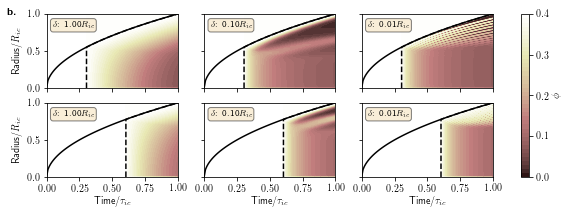

In [43]:
fig, ax =plt.subplots(2, 3, figsize=[10, 3], sharex=True, sharey=True)

for i_f, folder_R1 in enumerate(list_subfolder_R1):
    
    for j_f, folder in enumerate([folder_R1, list_subfolder_R10[i_f], list_subfolder_R100[i_f]]):
        file_stat, param, timesteps = extract_files(folder)
        name_max = max(timesteps.items(), key=itemgetter(1))[0]
        data = pd.read_csv(name_max, sep=" ")
        dr = data["radius"][1]-data["radius"][0]
        Radius = np.array(data["radius"].values)+ dr / 2.
        try: 
            supercooling = param["Dt_supercooling"]
            param["dot_r"] = param["Ric_adim"]/param["tic"]*param["growth_rate_exponent"]
        except: 
            supercooling = 0.
            param["dot_r"] = param["Ric_adim"]/param["time_max"]*param["growth_rate_exponent"]

        Time = supercooling+ np.array(sorted(timesteps.values()))
        rayon = np.zeros_like(Time)
        X, Y = np.meshgrid(Time, Radius)
        Z = 0.4*np.ones_like(X)

        for i, (name, time) in enumerate(sorted(timesteps.items(), key = itemgetter(1))):
            data = pd.read_csv(name, sep=" ")
            dr = data["radius"][1]-data["radius"][0]
            Porosity = np.array(data["porosity"].values)
            N_r = len(Porosity)
            Z[:N_r, i] = Porosity
            rayon[i] = data["radius"].iloc[-1]+dr/2

        X = X/param["tic"]
        Y = Y/param["Ric_adim"]
        levels = np.linspace(0, 0.4, 41)
        sc = ax[i_f, j_f].contourf(X, Y, Z, levels=levels, vmin=0, vmax = 0.4, cmap=plt.cm.get_cmap("pink"))

        ax[i_f, j_f].set_xlim([0., 1.])
        ax[i_f, j_f].set_ylim([0., 1.])

        # growth scenario lines (black lines)
        ax[i_f, j_f].plot(np.append([Time[0]], Time)/param["tic"], np.append([0], rayon)/param["Ric_adim"], "--k")
        t = np.linspace(0, Time[-1], 100)
        ax[i_f, j_f].plot(t/param["tic"], rayon[-1]*np.sqrt(t/Time[-1])/param["Ric_adim"], 'k')

        # legend
        textstr = ((
                        r"$\delta$: {:.2f}$R_{{ic}}$".format(1/param["Ric_adim"])))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax[i_f, j_f].text(0.05, 0.90, textstr, transform=ax[i_f, j_f].transAxes, fontsize=9,
            verticalalignment='top', bbox=props)

ax[0, 0].set_ylabel("Radius/$R_{{ic}}$")
ax[1, 0].set_ylabel("Radius/$R_{ic}$")

ax[1, 0].set_xlabel(r"Time/$\tau_{{ic}}$")
ax[1, 1].set_xlabel(r"Time/$\tau_{{ic}}$")
ax[1, 2].set_xlabel(r"Time/$\tau_{{ic}}$")

cb = fig.colorbar(sc, ticks=[0., 0.1, 0.2, 0.3, 0.4], ax=ax.ravel().tolist())
cb.set_label("$\phi$")

ax[0, 0].text(-0.3, 1.10, r"\textbf{b.}", transform=ax[0,0].transAxes, fontsize=11,
            verticalalignment='top')

plt.savefig("profiles_supercooling.pdf")